In [1]:
import os, sys, json, numpy as np, pandas as pd, pickle, itertools, logging
from sklearn.preprocessing import MinMaxScaler
from typing import TypeVar, Union, List, Literal, Tuple

In [2]:
from data.make_numpy import preprocessing_pipeline, UNZIPPED_FILE
from fundamental_domain_projections.example1 import fundamental_domain_projection

In [3]:
X, y = preprocessing_pipeline(UNZIPPED_FILE, extraction_key='h_1,1')

# Dataset Class

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [8]:
class FundamentalDomainProjectionDataset(Dataset):
    def __init__(
        self, 
        file:str=UNZIPPED_FILE,
        extraction_key:str='h_1,1',
        num_classes:int=None,
        use_one_hot:bool=False,
        use_cuda:bool=True,
        logger:logging.Logger=None,
    ):
        '''
        Arguments:
        ----------
            file (str): The input file to read. If compressed (i.e. `gunzip`-ed) will attempt to unzip it.

            extraction_key (str): The label to extract. If `None` will return the headers.
            
            num_classes (int): Number of classes in `y`. Defaults to `None`. If `None` will be set to 
                `max(y)+1`.
            
            use_one_hot (bool): whether or not to return `y` as a one-hot encoded vector or as its class label
            
            use_cuda (str): Defaults to `True`. Whether or not to put tensors on cuda. 
            
            logger (logging.Logger): Optional logger.

        Returns:
        ----------
            matrices (np.ndarray): A list of the matricies from the provided `file`.

            values (np.ndarray): A list of the headers from the provided `file` or a list of just the value
                specified by `extraction_key`.         
        '''
        if logger: 
            logger.info(f'Reading raw data file {file}.')
            logger.info(
                f'NOTE: extraction key ({extraction_key}) is specified. Only this value will be returned as `y`.'
            )
            
        X, y = preprocessing_pipeline(file, extraction_key=extraction_key)
        
        if logger: 
            logger.info(f'Running fundamental_domain_projection')
            logger.info(f'NOTE: this is only run once! Not once per epoch.')
                
        X = np.array(list(map(fundamental_domain_projection, X)))
        
        self.X = X
        self.y = y
        self.num_classes = np.max(y)+1 if num_classes is None else num_classes
        self.data_shape = self.X[0].shape
        self.use_cuda = use_cuda
        self.use_one_hot = use_one_hot
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.X[idx])
        y = torch.as_tensor(self.y[idx])
        if self.use_one_hot:
            y = nn.functional.one_hot(y, num_classes=self.num_classes)
        if self.use_cuda:
            x = x.cuda()
            y = y.cuda()        
        return x, y

In [9]:
def generate_dataloaders(
    dataset:Dataset, 
    training_ratio:float=0.7,
    batch_size:int=64
) -> Tuple[DataLoader, DataLoader]:
    '''
    Arguments:
    ----------
        dataset (Dataset): Current PyTorch Dataset to split into training 
            and validation sets
        
        training_ratio (float): Value between `[0, 1]`. Defaults to `0.7`. The 
            percent of samples to be used for training. The rest go to validation.

        batch_size (int): Defaults to `64`. The batch size to yield from `DataLoader`s.

    Returns:
    ---------
        train_loader (DataLoader): `DataLoader` for training data.
        valid_loader (DataLoader): `DataLoader` for validation data.
    '''
    n_train = np.floor(training_ratio * len(dataset)).astype(int)
    n_valid = len(dataset) - n_train

    train_set, valid_set = torch.utils.data.random_split(dataset, [n_train, n_valid])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)
    return train_loader, valid_loader

In [10]:
dataset = FundamentalDomainProjectionDataset(use_one_hot=False)

In [11]:
training_ratio = 0.7

n_train = np.floor(training_ratio * len(dataset)).astype(int)
n_valid = len(dataset) - n_train

train_set, valid_set = torch.utils.data.random_split(dataset, [n_train, n_valid])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=64, shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CNN Network

In [143]:
class FDPCNN(nn.Module):
    def __init__(self, data_shape, num_classes):
        super(FDPCNN, self).__init__()
        
        self.linears = nn.Sequential(
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(192, num_classes),           
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linears(x)
        logits = self.softmax(x)
        return logits

In [146]:
model = FDPCNN(dataset.data_shape, dataset.num_classes)
model.cuda()

FDPCNN(
  (linears): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=192, out_features=43, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [147]:
learning_rate = 0.1

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [148]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    use_one_hot = dataloader.dataset.dataset.use_one_hot
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.reshape(X.shape[0], 1, *list(X.shape)[1:])
        pred = model(X)
        y = y.float() if use_one_hot else y
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    use_one_hot = dataloader.dataset.dataset.use_one_hot
    
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.reshape(X.shape[0], 1, *list(X.shape)[1:])
            pred = model(X)
            y = y.float() if use_one_hot else y
            test_loss += loss_fn(pred, y).item()

            y = y.argmax(1) if use_one_hot else y            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 400
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.599918  [    0/54927]
loss: 3.566084  [ 6400/54927]
loss: 3.472315  [12800/54927]
loss: 3.614533  [19200/54927]
loss: 3.585360  [25600/54927]
loss: 3.546712  [32000/54927]
loss: 3.596921  [38400/54927]
loss: 3.614659  [44800/54927]
loss: 3.651735  [51200/54927]
Test Error: 
 Accuracy: 15.8%, Avg loss: 3.641177 

Epoch 2
-------------------------------
loss: 3.551020  [    0/54927]
loss: 3.503740  [ 6400/54927]
loss: 3.552280  [12800/54927]
loss: 3.622766  [19200/54927]
loss: 3.597818  [25600/54927]
loss: 3.473793  [32000/54927]
loss: 3.645785  [38400/54927]
loss: 3.524385  [44800/54927]
loss: 3.607200  [51200/54927]
Test Error: 
 Accuracy: 13.7%, Avg loss: 3.662803 

Epoch 3
-------------------------------
loss: 3.704706  [    0/54927]
loss: 3.634051  [ 6400/54927]
loss: 3.536264  [12800/54927]
loss: 3.532202  [19200/54927]
loss: 3.567227  [25600/54927]
loss: 3.608206  [32000/54927]
loss: 3.559037  [38400/54927]
loss: 3.525446  [44800/549

loss: 3.578242  [38400/54927]
loss: 3.596035  [44800/54927]
loss: 3.476599  [51200/54927]
Test Error: 
 Accuracy: 16.1%, Avg loss: 3.639293 

Epoch 24
-------------------------------
loss: 3.592819  [    0/54927]
loss: 3.628453  [ 6400/54927]
loss: 3.514652  [12800/54927]
loss: 3.618300  [19200/54927]
loss: 3.556534  [25600/54927]
loss: 3.591989  [32000/54927]
loss: 3.538673  [38400/54927]
loss: 3.690053  [44800/54927]
loss: 3.573216  [51200/54927]
Test Error: 
 Accuracy: 15.8%, Avg loss: 3.641176 

Epoch 25
-------------------------------
loss: 3.643974  [    0/54927]
loss: 3.624659  [ 6400/54927]
loss: 3.643705  [12800/54927]
loss: 3.707650  [19200/54927]
loss: 3.627967  [25600/54927]
loss: 3.619386  [32000/54927]
loss: 3.636067  [38400/54927]
loss: 3.643984  [44800/54927]
loss: 3.548047  [51200/54927]
Test Error: 
 Accuracy: 16.0%, Avg loss: 3.640391 

Epoch 26
-------------------------------
loss: 3.551467  [    0/54927]
loss: 3.597422  [ 6400/54927]
loss: 3.570105  [12800/54927]
l

loss: 3.473541  [ 6400/54927]
loss: 3.516634  [12800/54927]
loss: 3.606213  [19200/54927]
loss: 3.706607  [25600/54927]
loss: 3.527738  [32000/54927]
loss: 3.582042  [38400/54927]
loss: 3.534721  [44800/54927]
loss: 3.552401  [51200/54927]
Test Error: 
 Accuracy: 15.6%, Avg loss: 3.643140 

Epoch 47
-------------------------------
loss: 3.559717  [    0/54927]
loss: 3.533233  [ 6400/54927]
loss: 3.612846  [12800/54927]
loss: 3.583235  [19200/54927]
loss: 3.528589  [25600/54927]
loss: 3.520404  [32000/54927]
loss: 3.550051  [38400/54927]
loss: 3.534984  [44800/54927]
loss: 3.628406  [51200/54927]
Test Error: 
 Accuracy: 16.0%, Avg loss: 3.639956 

Epoch 48
-------------------------------
loss: 3.575307  [    0/54927]
loss: 3.471139  [ 6400/54927]
loss: 3.553612  [12800/54927]
loss: 3.484418  [19200/54927]
loss: 3.656883  [25600/54927]
loss: 3.645556  [32000/54927]
loss: 3.607626  [38400/54927]
loss: 3.563856  [44800/54927]
loss: 3.595691  [51200/54927]
Test Error: 
 Accuracy: 16.0%, Avg

loss: 3.551142  [51200/54927]
Test Error: 
 Accuracy: 15.5%, Avg loss: 3.644947 

Epoch 69
-------------------------------
loss: 3.643404  [    0/54927]
loss: 3.636102  [ 6400/54927]
loss: 3.548618  [12800/54927]
loss: 3.552255  [19200/54927]
loss: 3.596728  [25600/54927]
loss: 3.617588  [32000/54927]
loss: 3.580364  [38400/54927]
loss: 3.594868  [44800/54927]
loss: 3.484708  [51200/54927]
Test Error: 
 Accuracy: 15.9%, Avg loss: 3.641413 

Epoch 70
-------------------------------
loss: 3.550248  [    0/54927]
loss: 3.565409  [ 6400/54927]
loss: 3.597568  [12800/54927]
loss: 3.627784  [19200/54927]
loss: 3.580288  [25600/54927]
loss: 3.548282  [32000/54927]
loss: 3.587481  [38400/54927]
loss: 3.561142  [44800/54927]
loss: 3.530202  [51200/54927]
Test Error: 
 Accuracy: 16.0%, Avg loss: 3.639733 

Epoch 71
-------------------------------
loss: 3.550602  [    0/54927]
loss: 3.550357  [ 6400/54927]
loss: 3.581761  [12800/54927]
loss: 3.508054  [19200/54927]
loss: 3.580689  [25600/54927]
l

loss: 3.523794  [19200/54927]
loss: 3.581026  [25600/54927]
loss: 3.552867  [32000/54927]
loss: 3.550096  [38400/54927]
loss: 3.633992  [44800/54927]
loss: 3.579348  [51200/54927]
Test Error: 
 Accuracy: 15.8%, Avg loss: 3.641757 

Epoch 92
-------------------------------
loss: 3.474096  [    0/54927]
loss: 3.564997  [ 6400/54927]
loss: 3.605227  [12800/54927]
loss: 3.395406  [19200/54927]
loss: 3.625253  [25600/54927]
loss: 3.537911  [32000/54927]
loss: 3.496029  [38400/54927]
loss: 3.598278  [44800/54927]
loss: 3.519014  [51200/54927]
Test Error: 
 Accuracy: 15.6%, Avg loss: 3.643520 

Epoch 93
-------------------------------
loss: 3.527817  [    0/54927]
loss: 3.644756  [ 6400/54927]
loss: 3.565977  [12800/54927]
loss: 3.630393  [19200/54927]
loss: 3.565717  [25600/54927]
loss: 3.544010  [32000/54927]
loss: 3.555246  [38400/54927]
loss: 3.673206  [44800/54927]
loss: 3.705484  [51200/54927]
Test Error: 
 Accuracy: 15.8%, Avg loss: 3.642168 

Epoch 94
-------------------------------
l

loss: 3.583696  [ 6400/54927]
loss: 3.561662  [12800/54927]
loss: 3.565843  [19200/54927]
loss: 3.550362  [25600/54927]
loss: 3.411615  [32000/54927]
loss: 3.551563  [38400/54927]
loss: 3.569674  [44800/54927]
loss: 3.581886  [51200/54927]
Test Error: 
 Accuracy: 15.7%, Avg loss: 3.642960 

Epoch 115
-------------------------------
loss: 3.566123  [    0/54927]
loss: 3.384326  [ 6400/54927]
loss: 3.581579  [12800/54927]
loss: 3.475299  [19200/54927]
loss: 3.597043  [25600/54927]
loss: 3.597219  [32000/54927]
loss: 3.610591  [38400/54927]
loss: 3.534717  [44800/54927]
loss: 3.534759  [51200/54927]
Test Error: 
 Accuracy: 15.1%, Avg loss: 3.649553 

Epoch 116
-------------------------------
loss: 3.614523  [    0/54927]
loss: 3.504956  [ 6400/54927]
loss: 3.490938  [12800/54927]
loss: 3.645182  [19200/54927]
loss: 3.539888  [25600/54927]
loss: 3.530289  [32000/54927]
loss: 3.535195  [38400/54927]
loss: 3.522820  [44800/54927]
loss: 3.628326  [51200/54927]
Test Error: 
 Accuracy: 15.7%, A

loss: 3.582275  [51200/54927]
Test Error: 
 Accuracy: 13.2%, Avg loss: 3.668266 

Epoch 137
-------------------------------
loss: 3.581227  [    0/54927]
loss: 3.597164  [ 6400/54927]
loss: 3.615652  [12800/54927]
loss: 3.612389  [19200/54927]
loss: 3.443225  [25600/54927]
loss: 3.487883  [32000/54927]
loss: 3.537701  [38400/54927]
loss: 3.520034  [44800/54927]
loss: 3.581646  [51200/54927]
Test Error: 
 Accuracy: 15.7%, Avg loss: 3.643440 

Epoch 138
-------------------------------
loss: 3.643860  [    0/54927]
loss: 3.529443  [ 6400/54927]
loss: 3.597273  [12800/54927]
loss: 3.586090  [19200/54927]
loss: 3.581635  [25600/54927]
loss: 3.564380  [32000/54927]
loss: 3.550358  [38400/54927]
loss: 3.565990  [44800/54927]
loss: 3.517869  [51200/54927]
Test Error: 
 Accuracy: 15.2%, Avg loss: 3.647914 

Epoch 139
-------------------------------
loss: 3.543715  [    0/54927]
loss: 3.550276  [ 6400/54927]
loss: 3.537154  [12800/54927]
loss: 3.597199  [19200/54927]
loss: 3.558601  [25600/54927

loss: 3.564305  [19200/54927]
loss: 3.597359  [25600/54927]
loss: 3.550966  [32000/54927]
loss: 3.644570  [38400/54927]
loss: 3.543604  [44800/54927]
loss: 3.505489  [51200/54927]
Test Error: 
 Accuracy: 15.7%, Avg loss: 3.643128 

Epoch 160
-------------------------------
loss: 3.540284  [    0/54927]
loss: 3.628269  [ 6400/54927]
loss: 3.534503  [12800/54927]
loss: 3.505410  [19200/54927]
loss: 3.530600  [25600/54927]
loss: 3.548644  [32000/54927]
loss: 3.576830  [38400/54927]
loss: 3.554486  [44800/54927]
loss: 3.552213  [51200/54927]
Test Error: 
 Accuracy: 15.4%, Avg loss: 3.646438 

Epoch 161
-------------------------------
loss: 3.534674  [    0/54927]
loss: 3.550370  [ 6400/54927]
loss: 3.534759  [12800/54927]
loss: 3.595927  [19200/54927]
loss: 3.597129  [25600/54927]
loss: 3.581434  [32000/54927]
loss: 3.409875  [38400/54927]
loss: 3.612881  [44800/54927]
loss: 3.672607  [51200/54927]
Test Error: 
 Accuracy: 15.8%, Avg loss: 3.641744 

Epoch 162
------------------------------

loss: 3.582532  [ 6400/54927]
loss: 3.612772  [12800/54927]
loss: 3.534636  [19200/54927]
loss: 3.589167  [25600/54927]
loss: 3.628404  [32000/54927]
loss: 3.550326  [38400/54927]
loss: 3.488237  [44800/54927]
loss: 3.566045  [51200/54927]
Test Error: 
 Accuracy: 15.2%, Avg loss: 3.648120 

Epoch 183
-------------------------------
loss: 3.597225  [    0/54927]
loss: 3.603511  [ 6400/54927]
loss: 3.566610  [12800/54927]
loss: 3.523294  [19200/54927]
loss: 3.546302  [25600/54927]
loss: 3.561657  [32000/54927]
loss: 3.467325  [38400/54927]
loss: 3.581538  [44800/54927]
loss: 3.550480  [51200/54927]
Test Error: 
 Accuracy: 15.6%, Avg loss: 3.644322 

Epoch 184
-------------------------------
loss: 3.628395  [    0/54927]
loss: 3.590369  [ 6400/54927]
loss: 3.553442  [12800/54927]
loss: 3.566007  [19200/54927]
loss: 3.546882  [25600/54927]
loss: 3.597973  [32000/54927]
loss: 3.562893  [38400/54927]
loss: 3.596384  [44800/54927]
loss: 3.568706  [51200/54927]
Test Error: 
 Accuracy: 15.6%, A

# Fully Connected Linear Network

In [32]:
class FDPNN(nn.Module):
    def __init__(self, data_shape, num_classes):
        super(FDPNN, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linears = nn.Sequential(
            nn.Linear(np.multiply(*data_shape), 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),            
        )
        self.linears = nn.Sequential(
            nn.Linear(np.multiply(*data_shape), 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
#             nn.Linear(256, 128),
#             nn.ReLU(),
            nn.Linear(50, num_classes),            
        )
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linears(x)
        logits = self.softmax(x)
        return logits

In [33]:
model = FDPNN(dataset.data_shape, dataset.num_classes)
model.cuda()

FDPNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linears): Sequential(
    (0): Linear(in_features=104, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=43, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [34]:
learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    use_one_hot = dataloader.dataset.dataset.use_one_hot
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y = y.float() if use_one_hot else y
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    use_one_hot = dataloader.dataset.dataset.use_one_hot
    
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.float() if use_one_hot else y
            test_loss += loss_fn(pred, y).item()

            y = y.argmax(1) if use_one_hot else y            
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [36]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.759483  [    0/54927]
loss: 3.662080  [ 6400/54927]
loss: 3.646879  [12800/54927]
loss: 3.689054  [19200/54927]
loss: 3.689847  [25600/54927]
loss: 3.672641  [32000/54927]
loss: 3.674374  [38400/54927]
loss: 3.590564  [44800/54927]
loss: 3.641473  [51200/54927]
Test Error: 
 Accuracy: 16.9%, Avg loss: 3.630799 

Epoch 2
-------------------------------
loss: 3.658526  [    0/54927]
loss: 3.619642  [ 6400/54927]
loss: 3.621393  [12800/54927]
loss: 3.709626  [19200/54927]
loss: 3.628158  [25600/54927]
loss: 3.654631  [32000/54927]
loss: 3.566876  [38400/54927]
loss: 3.623794  [44800/54927]
loss: 3.635875  [51200/54927]
Test Error: 
 Accuracy: 17.1%, Avg loss: 3.627501 

Epoch 3
-------------------------------
loss: 3.648937  [    0/54927]
loss: 3.617840  [ 6400/54927]
loss: 3.620517  [12800/54927]
loss: 3.566114  [19200/54927]
loss: 3.599009  [25600/54927]
loss: 3.682562  [32000/54927]
loss: 3.675303  [38400/54927]
loss: 3.593642  [44800/549

loss: 3.550550  [38400/54927]
loss: 3.541887  [44800/54927]
loss: 3.533041  [51200/54927]
Test Error: 
 Accuracy: 18.3%, Avg loss: 3.616114 

Epoch 24
-------------------------------
loss: 3.435330  [    0/54927]
loss: 3.604980  [ 6400/54927]
loss: 3.542418  [12800/54927]
loss: 3.532160  [19200/54927]
loss: 3.468518  [25600/54927]
loss: 3.472802  [32000/54927]
loss: 3.504923  [38400/54927]
loss: 3.585826  [44800/54927]
loss: 3.521581  [51200/54927]
Test Error: 
 Accuracy: 18.4%, Avg loss: 3.615667 

Epoch 25
-------------------------------
loss: 3.558554  [    0/54927]
loss: 3.557509  [ 6400/54927]
loss: 3.494273  [12800/54927]
loss: 3.514682  [19200/54927]
loss: 3.443319  [25600/54927]
loss: 3.574260  [32000/54927]
loss: 3.493351  [38400/54927]
loss: 3.584423  [44800/54927]
loss: 3.595476  [51200/54927]
Test Error: 
 Accuracy: 18.1%, Avg loss: 3.618354 

Epoch 26
-------------------------------
loss: 3.488586  [    0/54927]
loss: 3.516490  [ 6400/54927]
loss: 3.495048  [12800/54927]
l

loss: 3.491956  [ 6400/54927]
loss: 3.523225  [12800/54927]
loss: 3.413625  [19200/54927]
loss: 3.591523  [25600/54927]
loss: 3.510161  [32000/54927]
loss: 3.504923  [38400/54927]
loss: 3.493776  [44800/54927]
loss: 3.541274  [51200/54927]
Test Error: 
 Accuracy: 18.6%, Avg loss: 3.613686 

Epoch 47
-------------------------------
loss: 3.577425  [    0/54927]
loss: 3.396782  [ 6400/54927]
loss: 3.400434  [12800/54927]
loss: 3.585890  [19200/54927]
loss: 3.529329  [25600/54927]
loss: 3.448527  [32000/54927]
loss: 3.566071  [38400/54927]
loss: 3.445629  [44800/54927]
loss: 3.517675  [51200/54927]
Test Error: 
 Accuracy: 18.4%, Avg loss: 3.615410 

Epoch 48
-------------------------------
loss: 3.523364  [    0/54927]
loss: 3.506537  [ 6400/54927]
loss: 3.512434  [12800/54927]
loss: 3.537014  [19200/54927]
loss: 3.426142  [25600/54927]
loss: 3.475918  [32000/54927]
loss: 3.480966  [38400/54927]
loss: 3.467958  [44800/54927]
loss: 3.620106  [51200/54927]
Test Error: 
 Accuracy: 18.5%, Avg

KeyboardInterrupt: 

# Gradient Boost

In [155]:
from sklearn import ensemble

In [171]:
# Gradient boosting in action...
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)

model.fit(dataset.X[train_set.indices].reshape(-1, 4 * 26), dataset.y[train_set.indices])

/home/solstice/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=4,
                          n_estimators=1000)

In [172]:
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(dataset.X[train_set.indices].reshape(-1, 4 * 26), dataset.y[train_set.indices])
print('R2 sq: ', model_score)

y_predicted = model.predict(dataset.X[valid_set.indices].reshape(-1, 4 * 26))
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(dataset.y[valid_set.indices], y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(dataset.y[valid_set.indices], y_predicted))

R2 sq:  0.8003930233724559
Mean squared error: 2.95
Test Variance score: 0.79


In [173]:
acc = (np.sum(np.round(y_predicted) == dataset.y[valid_set.indices])) / len(dataset.y[valid_set.indices])
acc

0.2373306146722739

# Dimensional Reduction

In [8]:
import phate
phate_op = phate.PHATE(n_components=10, n_jobs=-1)
Y_phate = phate_op.fit_transform(dataset.X.reshape(-1, np.multiply(*list(dataset.X.shape)[1:])))

Calculating PHATE...
  Running PHATE on 78468 observations and 104 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.63 seconds.
    Calculating KNN search...
    Calculated KNN search in 114.77 seconds.
    Calculating affinities...
    Calculated affinities in 56.42 seconds.
  Calculated graph and diffusion operator in 171.93 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 8.81 seconds.
    Calculating KMeans...


/home/solstice/anaconda3/envs/ml/lib/python3.9/site-packages/threadpoolctl.py:762: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


    Calculated KMeans in 4.44 seconds.
  Calculated landmark operator in 15.22 seconds.
  Calculating optimal t...
    Automatically selected t = 13
  Calculated optimal t in 0.74 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.41 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 90.51 seconds.
Calculated PHATE in 278.84 seconds.


In [36]:
import seaborn as sns, matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [14]:
df = pd.DataFrame(Y_phate, columns=[f'd{i}' for i in range(1, 11)]).join(pd.DataFrame(dataset.y, columns=['Hodge']))

In [49]:
components = phate_op.graph.data_pca.components_
loadings = phate_op.graph.data_nu

In [65]:
import pickle
from data.make_numpy import DATA_DIR
df.to_pickle(os.path.join(DATA_DIR, 'df_phate.pickle'))

with open(os.path.join(DATA_DIR, 'pca_loadings.pickle'), 'wb') as f:
    pickle.dump(loadings, f)

with open(os.path.join(DATA_DIR, 'pca_components.pickle'), 'wb') as f:
    pickle.dump(components, f)

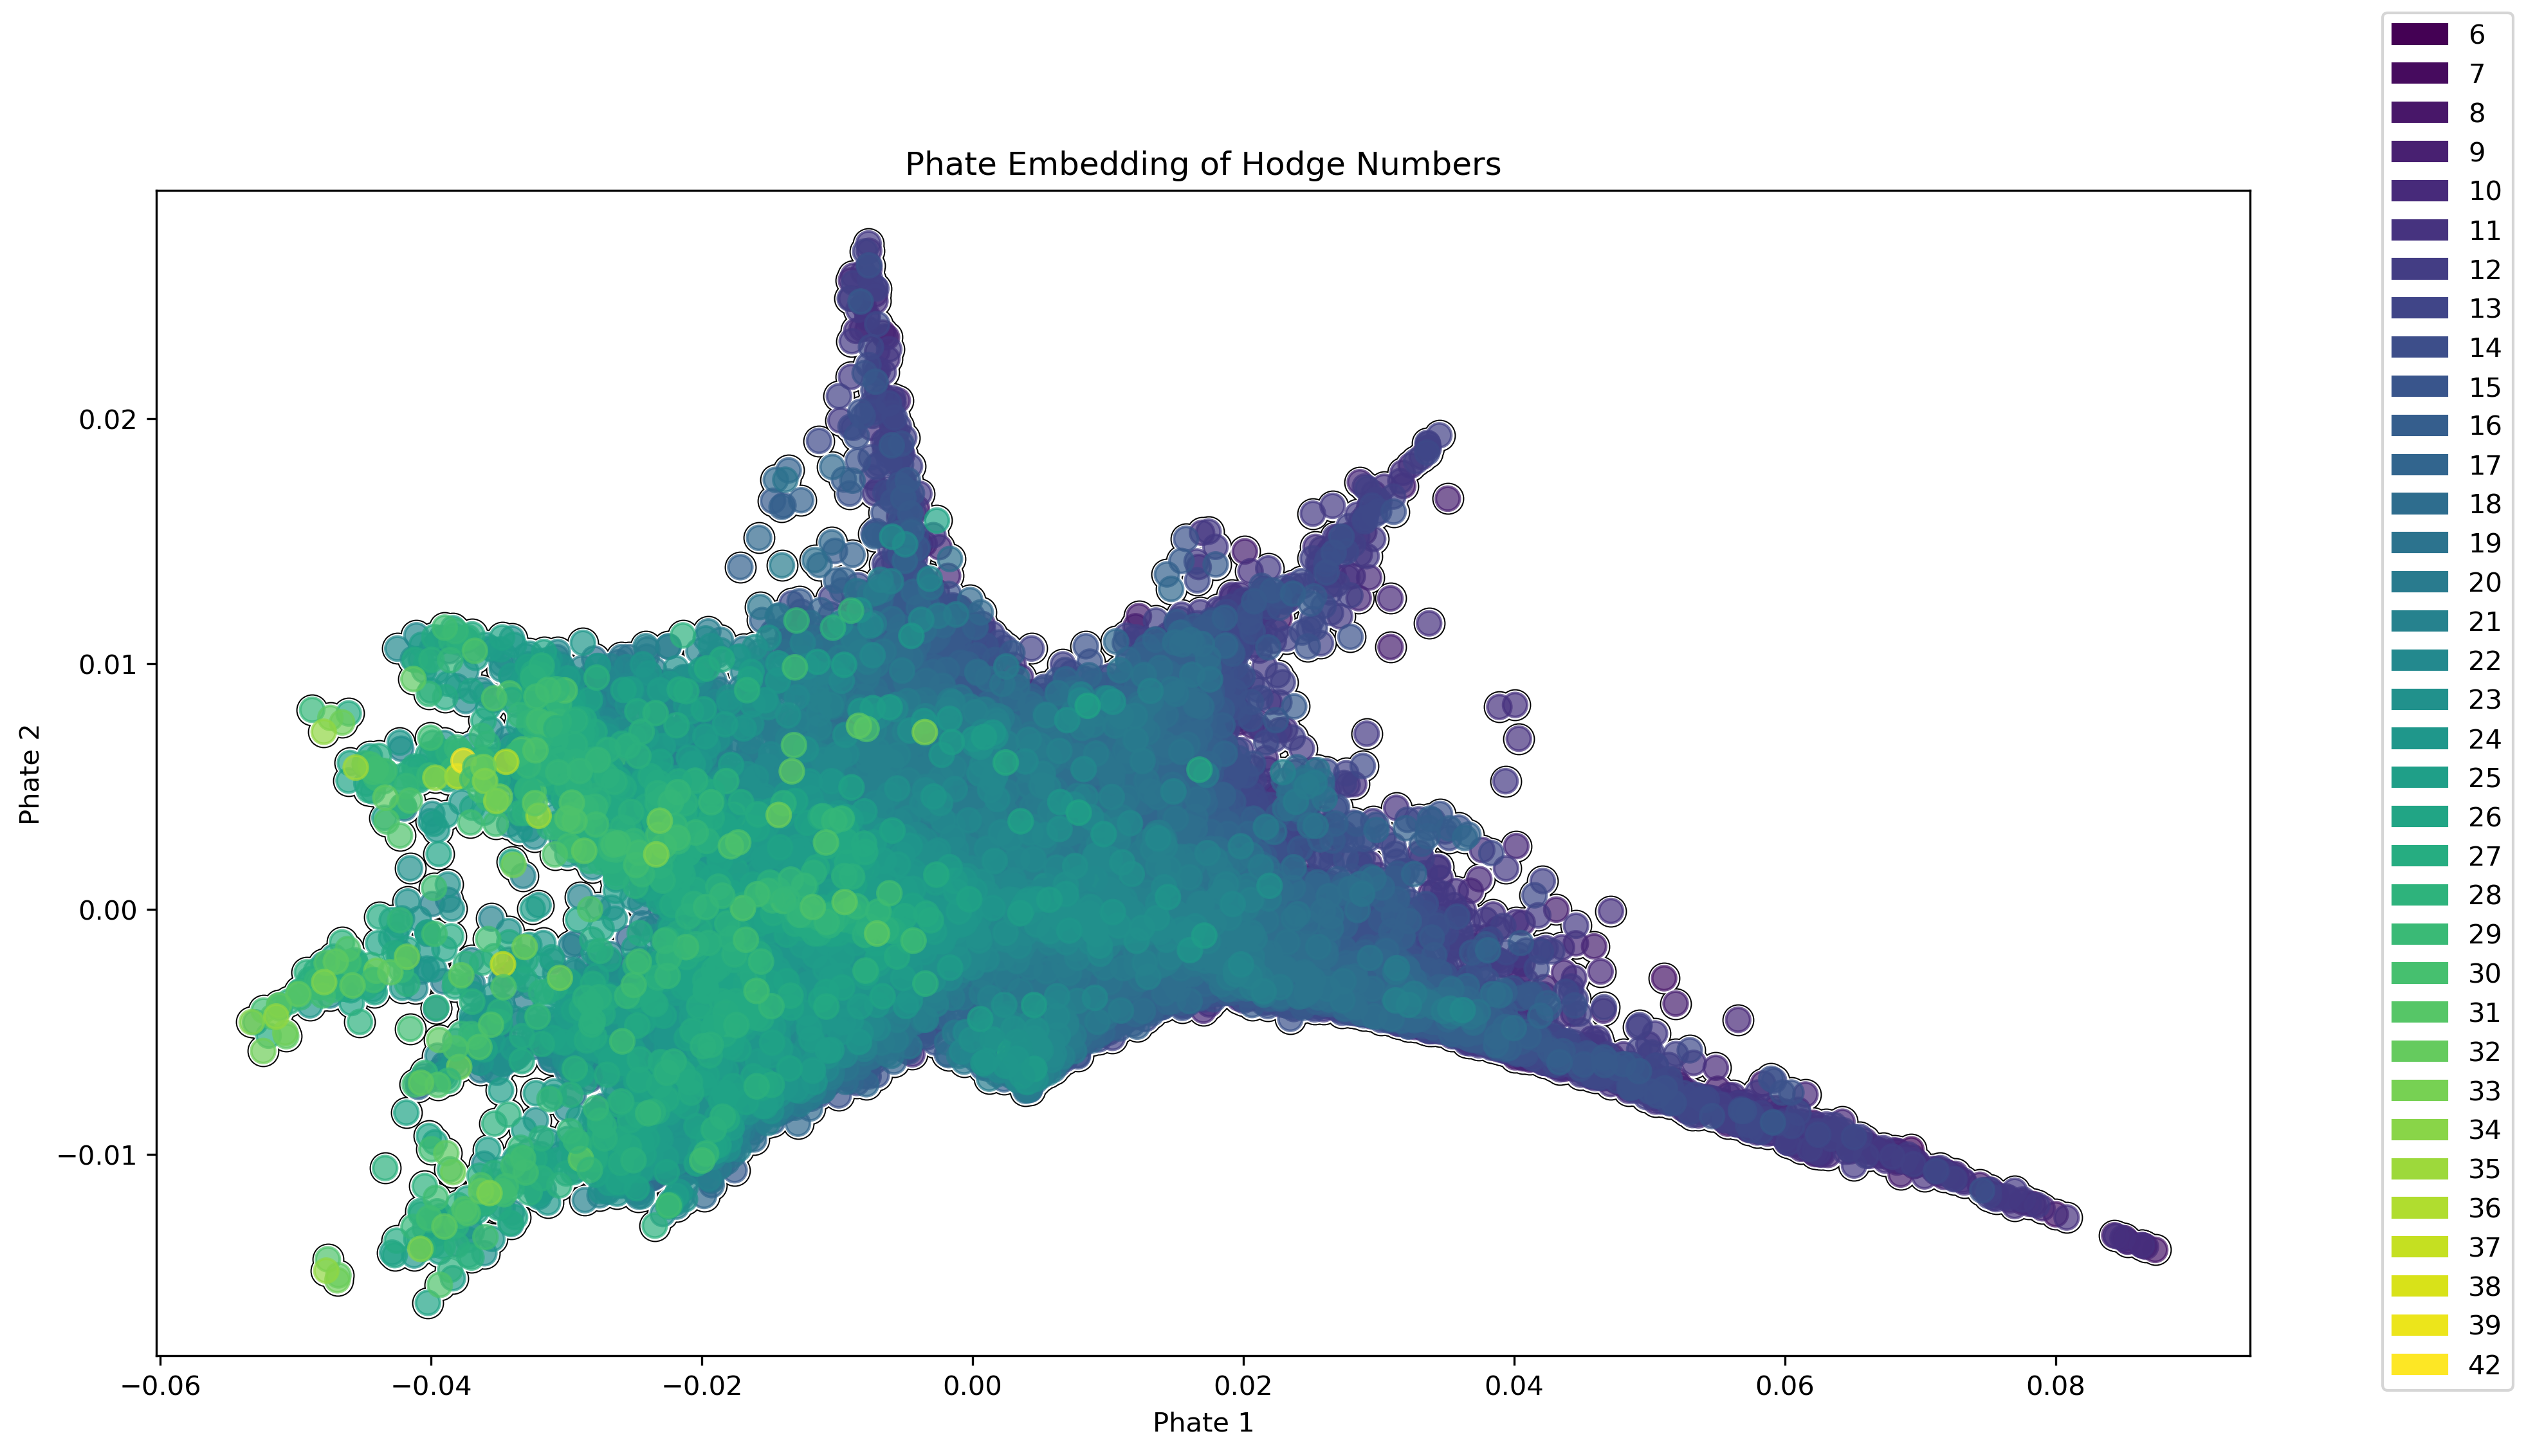

In [48]:
fig = plt.figure(figsize=(14, 8), dpi=300)
ax = fig.add_subplot(1,1,1)
ax.set_title('Phate Embedding of Hodge Numbers')
ax.set_xlabel('Phate 1')
ax.set_ylabel('Phate 2')
ax.scatter(
    df.d1, df.d2, 
    s=120, c='black', cmap='viridis'
)
ax.scatter(
    df.d1, df.d2, 
    s=100, c='white', cmap='viridis'
)
ax.scatter(
    df.d1, df.d2, 
    s=80, c=df.Hodge, cmap='viridis', alpha=0.7,
    marker='o', edgecolors=None
)
cmap = plt.get_cmap()
fig.legend(
    handles=[
        mpatches.Patch(color=cmap(i/(len(np.unique(df.Hodge))-1)), label=hodge)
        for i, hodge in enumerate(np.unique(df.Hodge))
    ]
)

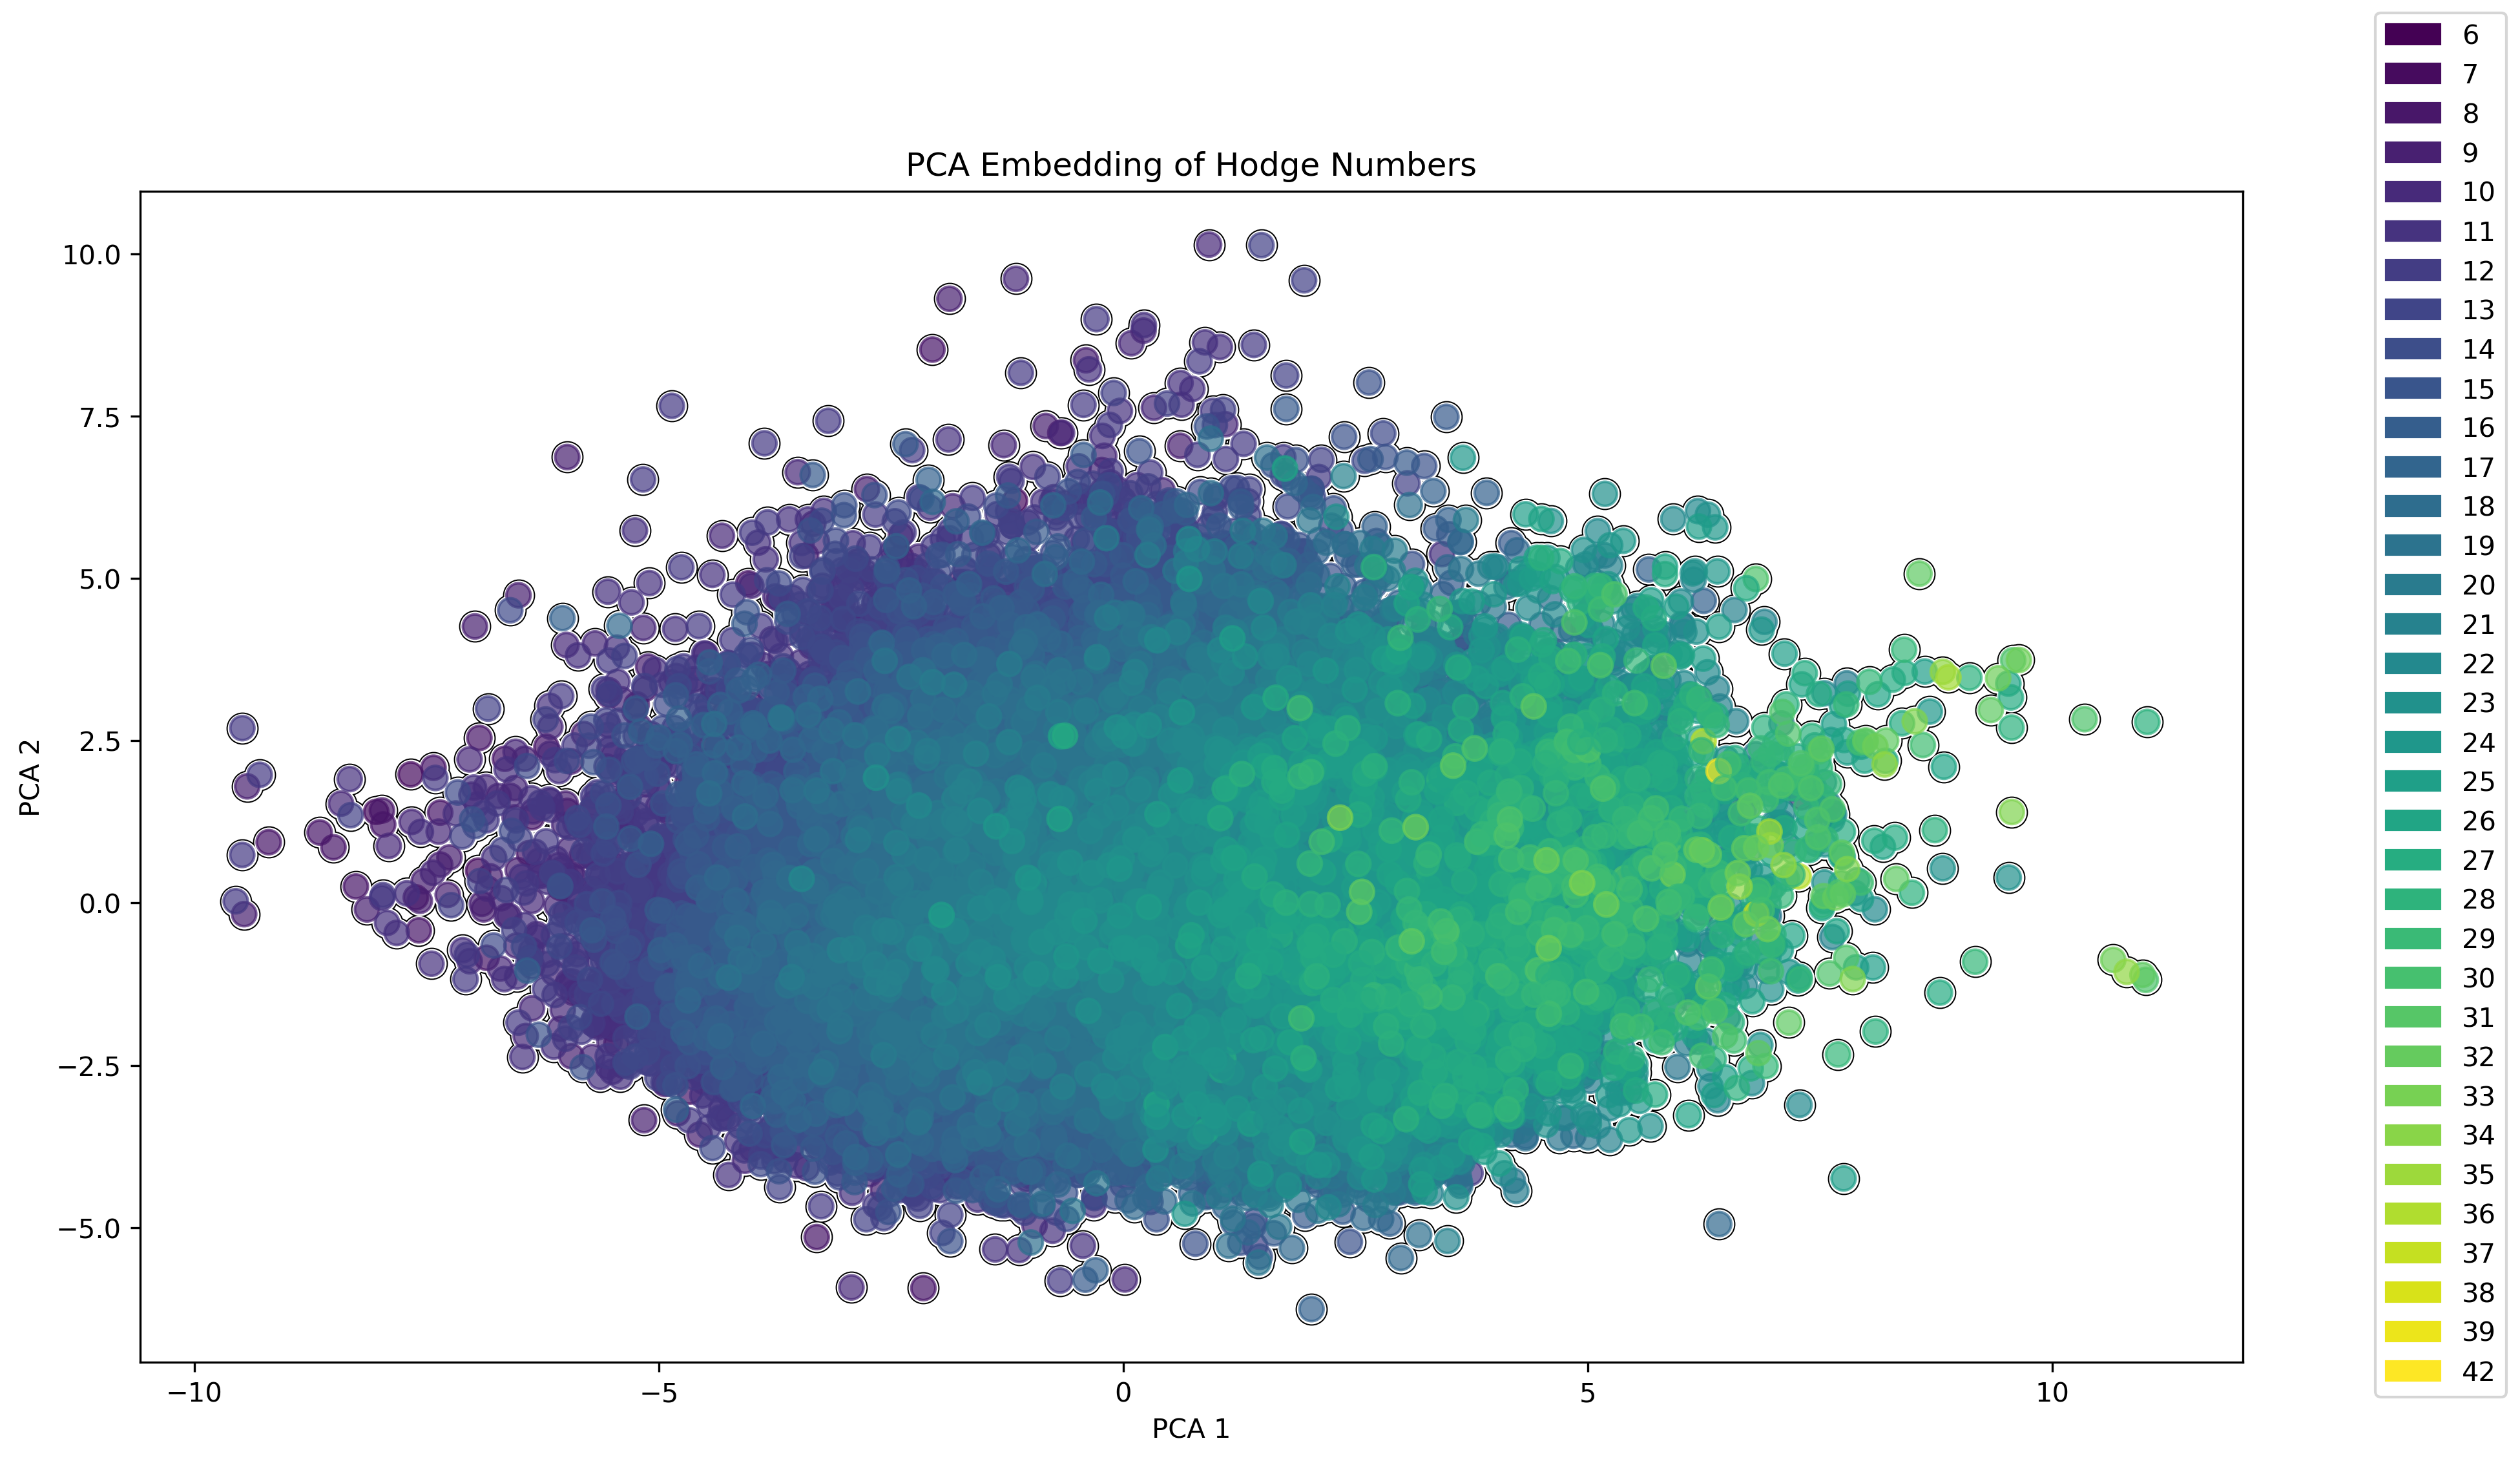

In [50]:
fig = plt.figure(figsize=(14, 8), dpi=300)
ax = fig.add_subplot(1,1,1)
ax.set_title('PCA Embedding of Hodge Numbers')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.scatter(
    loadings[:, 0], loadings[:, 1],
    s=120, c='black', cmap='viridis'
)
ax.scatter(
    loadings[:, 0], loadings[:, 1],
    s=100, c='white', cmap='viridis'
)
ax.scatter(
    loadings[:, 0], loadings[:, 1],
    s=80, c=df.Hodge, cmap='viridis', alpha=0.7,
    marker='o', edgecolors=None
)
cmap = plt.get_cmap()
fig.legend(
    handles=[
        mpatches.Patch(color=cmap(i/(len(np.unique(df.Hodge))-1)), label=hodge)
        for i, hodge in enumerate(np.unique(df.Hodge))
    ]
)

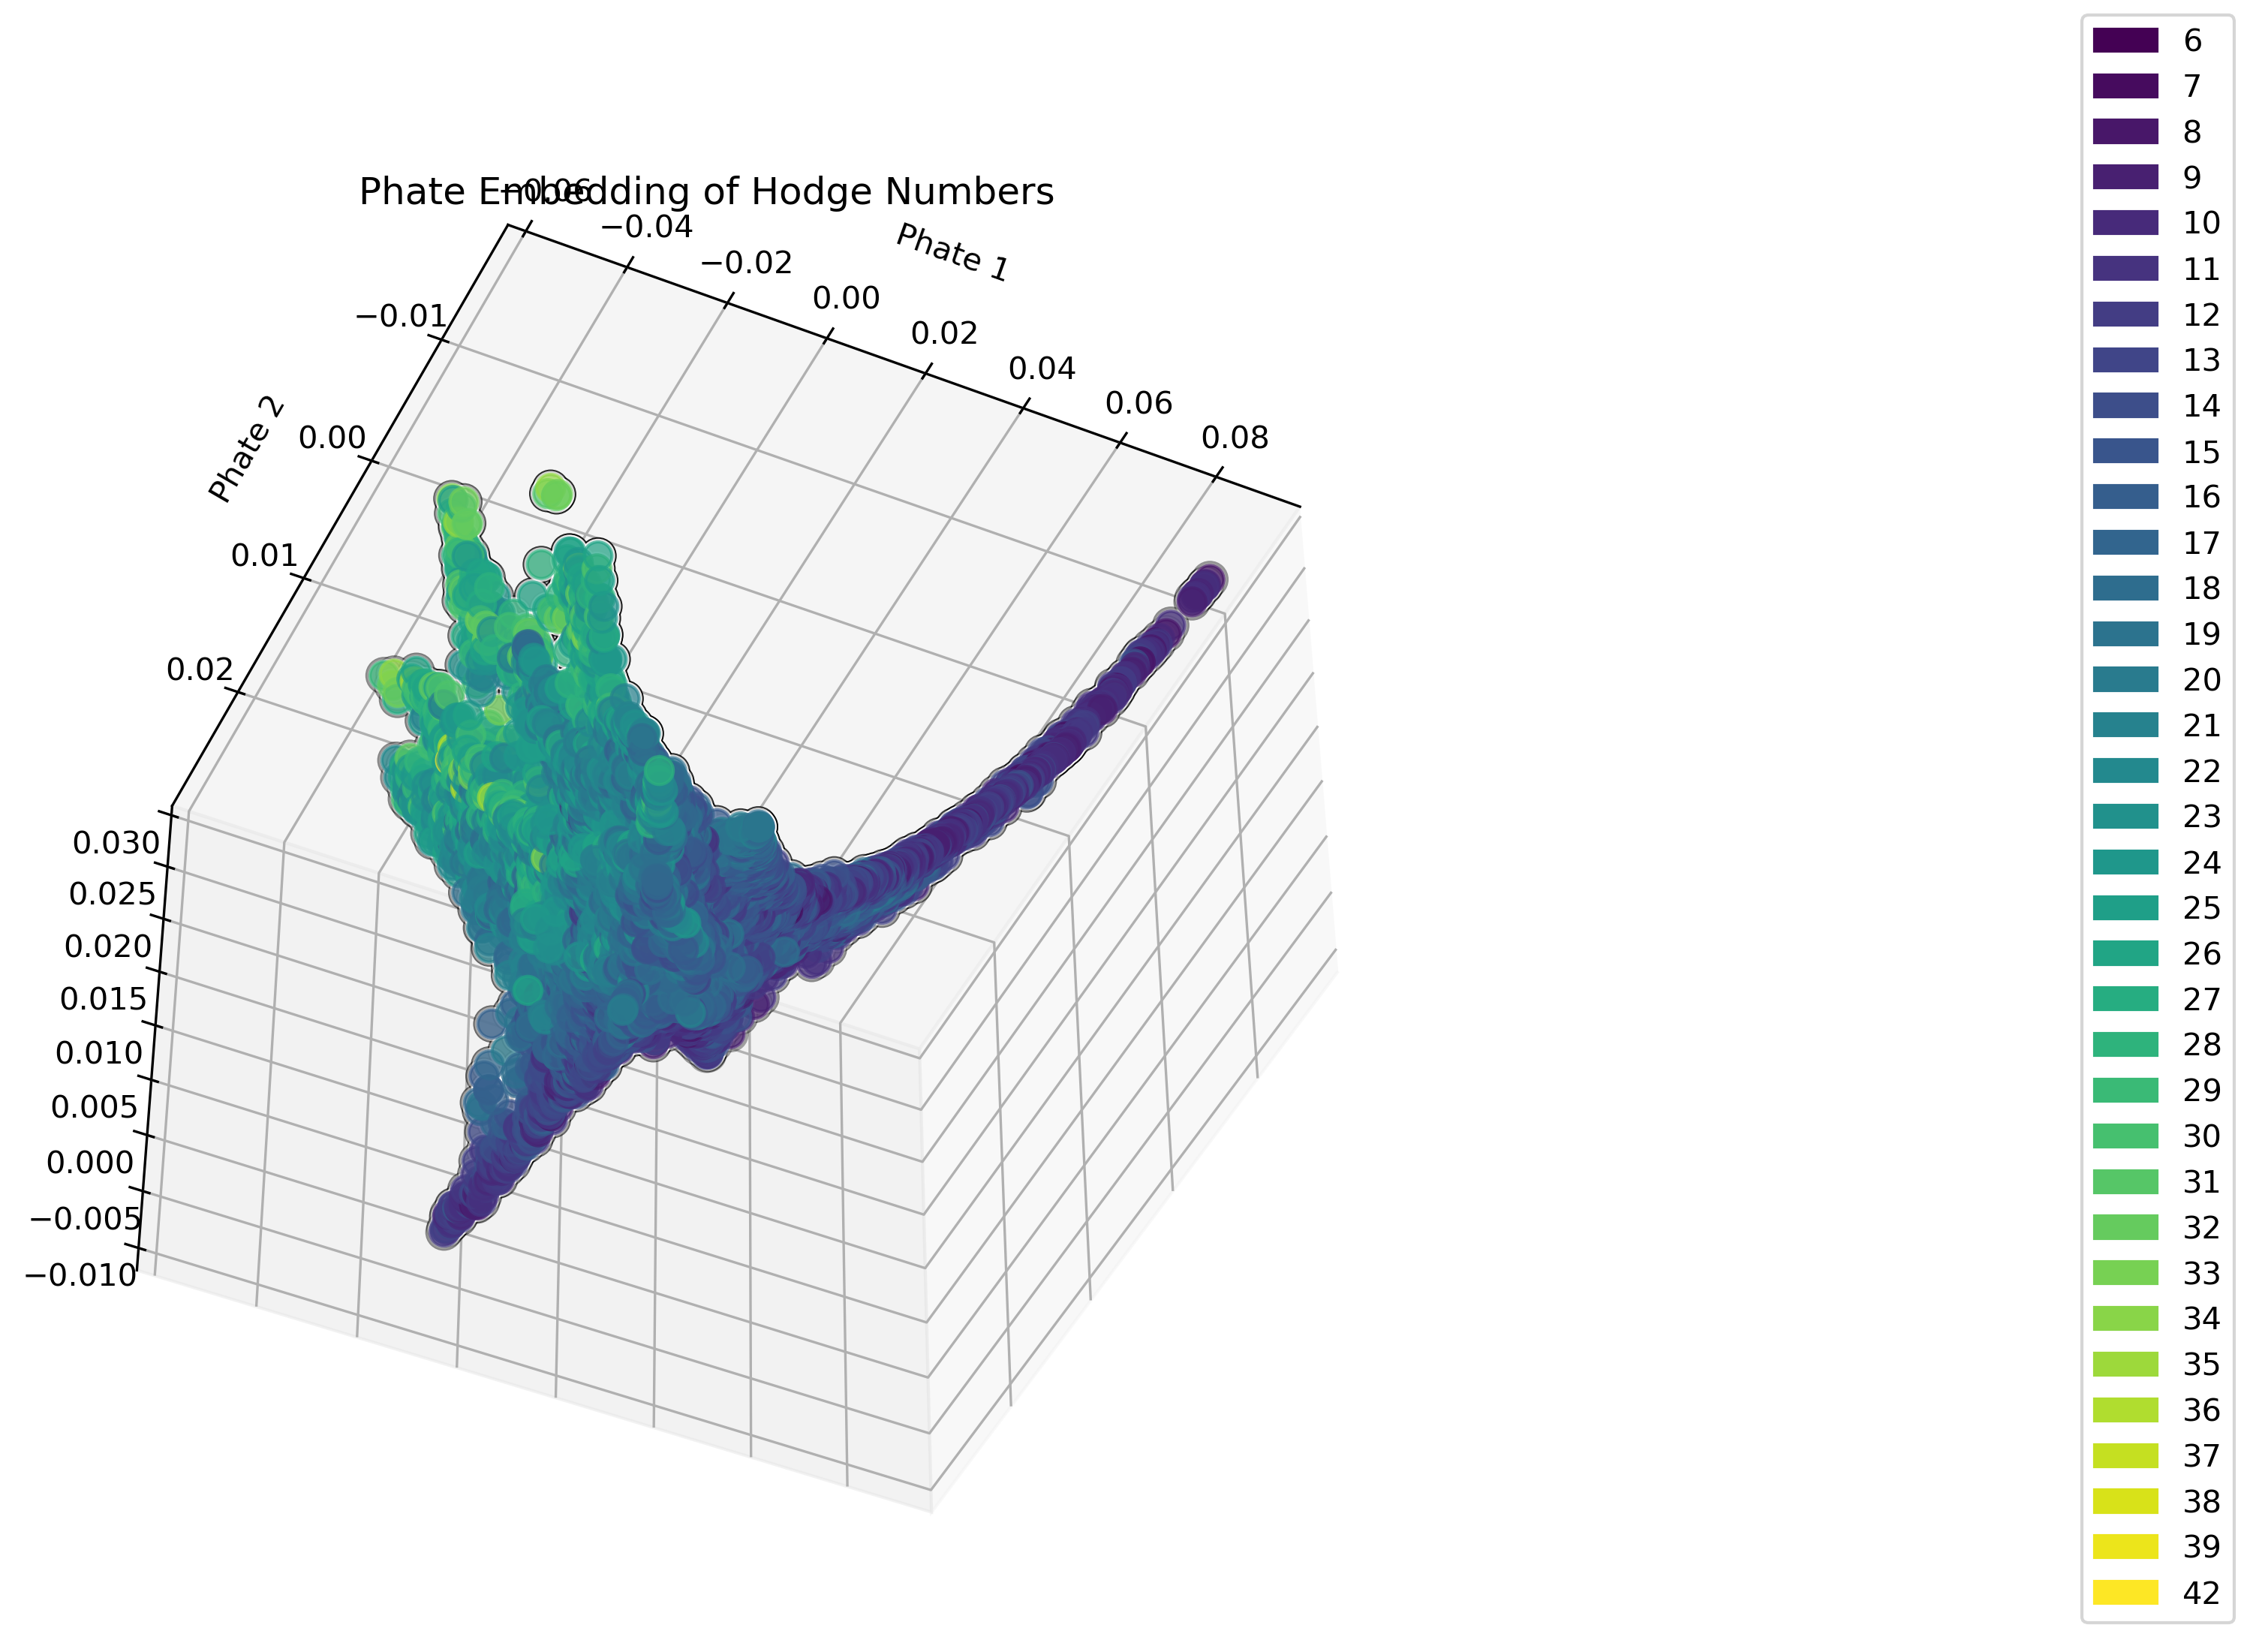

In [63]:
fig = plt.figure(figsize=(14, 8), dpi=300)
ax = fig.add_subplot(1,1,1, projection='3d')
ax.set_title('Phate Embedding of Hodge Numbers')
ax.set_xlabel('Phate 1')
ax.set_ylabel('Phate 2')
ax.scatter(
    df.d1, df.d2, df.d3,
    s=120, c='black', cmap='viridis'
)
ax.scatter(
    df.d1, df.d2, df.d3,
    s=100, c='white', cmap='viridis'
)
ax.scatter(
    df.d1, df.d2, df.d3,
    s=80, c=df.Hodge, cmap='viridis', alpha=0.7,
    marker='o', edgecolors=None, 
)
cmap = plt.get_cmap()
fig.legend(
    handles=[
        mpatches.Patch(color=cmap(i/(len(np.unique(df.Hodge))-1)), label=hodge)
        for i, hodge in enumerate(np.unique(df.Hodge))
    ]
)
ax.elev = 45
ax.azim = 45

ax.elev = 245
ax.azim = -45

ax.elev = -45
ax.azim = 245

# Gradient boost on Phate

In [66]:
from sklearn import ensemble

In [67]:
# Gradient boosting in action...
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)

model.fit(Y_phate[train_set.indices], dataset.y[train_set.indices])

/home/solstice/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=4,
                          n_estimators=1000)

In [68]:
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(Y_phate[train_set.indices], dataset.y[train_set.indices])
print('R2 sq: ', model_score)

y_predicted = model.predict(Y_phate[valid_set.indices])
# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(dataset.y[valid_set.indices], y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(dataset.y[valid_set.indices], y_predicted))

R2 sq:  0.6183591980963378
Mean squared error: 5.67
Test Variance score: 0.60


In [69]:
acc = (np.sum(np.round(y_predicted) == dataset.y[valid_set.indices])) / len(dataset.y[valid_set.indices])
acc

0.1666029480480863